# Titanic Survival Prediction

**Objective:**
Develop a production-ready machine learning model to predict the probability of passenger survival on the Titanic, and export the trained pipeline for
deployment via a REST API.

**Project Type:** End-to-End Machine Learning<br/>
**Author:** Htay Aung<br/>
**Date:** Jan 7, 2026

## Table of Contents
1. [Problem Statement](#problem-statement)
2. [Dataset Overview](#dataset-overview)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Data Cleaning](#data-cleaning)
5. [Feature Engineering](#feature-engineering)
6. [Modeling Approach](#modeling-approach)
7. [Model Training](#model-training)
8. [Model Evaluation](#model-evaluation)
9. [Export Model Artifacts](#export-model)
10. [Conclusion & Future Improvements](#conclusion)

## 1. Problem Statement <a id="problem-statement"></a>

The goal of this project is to build a supervised machine learning model that predicts whether a passenger survived the Titanic disaster based on demographic and travel-related attributes.

This problem is formulated as a binary classification task. The final trained model will be exported and used for real-time inference through a secured REST API.

## 2. Dataset Overview <a id="dataset-overview"></a>

In [2]:
import pandas as pd

df = pd.read_csv("../data/raw/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Total records: 891
- Total features: 12
- Target variable: `Survived`
  - 0 = Did not survive
  - 1 = Survived

The dataset contains both numerical and categorical features, with missing values present in several columns that require preprocessing.

## 3. Exploratory Data Analysis (EDA) <a id="eda"></a>

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")

### 3.1. Survival Distribution

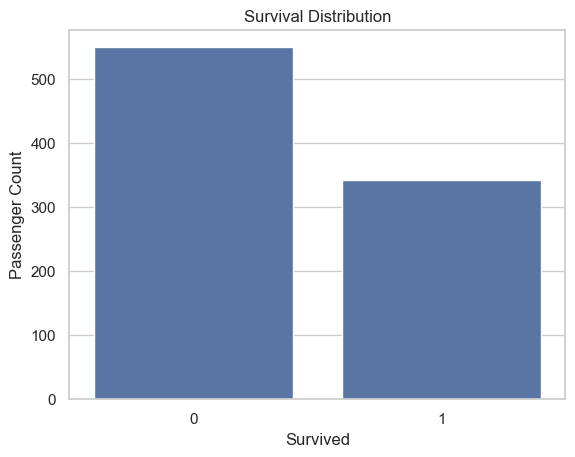

In [6]:
sns.countplot(x="Survived", data=df)
plt.title("Survival Distribution")
plt.xlabel("Survived")
plt.ylabel("Passenger Count")
plt.show()

The dataset is moderately imbalanced, with more passengers not surviving than surviving. However, the imbalance is not severe enough to require resampling.

### 3.2 Survival Rate by Sex

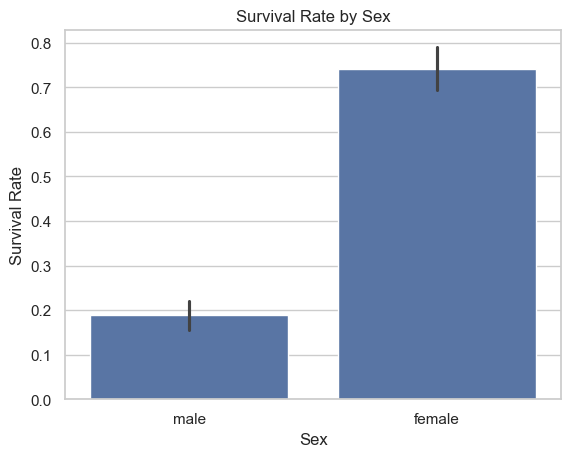

In [7]:
sns.barplot(
    x="Sex",
    y="Survived",
    data=df,
    estimator=lambda x: sum(x) / len(x)
)
plt.title("Survival Rate by Sex")
plt.ylabel("Survival Rate")
plt.show()

Female passengers demonstrate a significantly higher survival rate, indicating sex is a strong predictive feature.

### 3.3 Survival Rate by Passenger Class

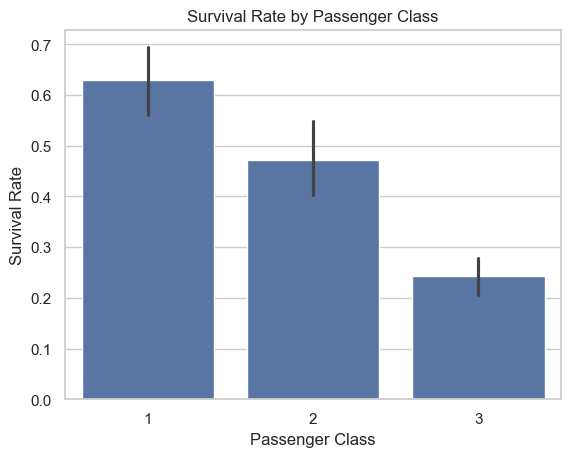

In [8]:
sns.barplot(
    x="Pclass",
    y="Survived",
    data=df,
    estimator=lambda x: sum(x) / len(x)
)
plt.title("Survival Rate by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.show()

Passengers in higher classes exhibit substantially higher survival rates, suggesting socioeconomic status played a major role in survival outcomes.

### 3.4 Age Distribution by Survival Status

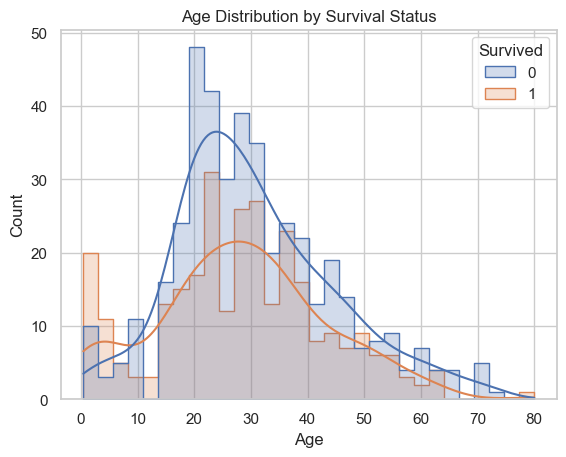

In [9]:
sns.histplot(
    data=df,
    x="Age",
    hue="Survived",
    bins=30,
    kde=True,
    element="step"
)
plt.title("Age Distribution by Survival Status")
plt.show()

Younger passengers tend to have higher survival rates, although age alone does not perfectly separate survivors from non-survivors.

### 3.5 Missing Values Heatmap

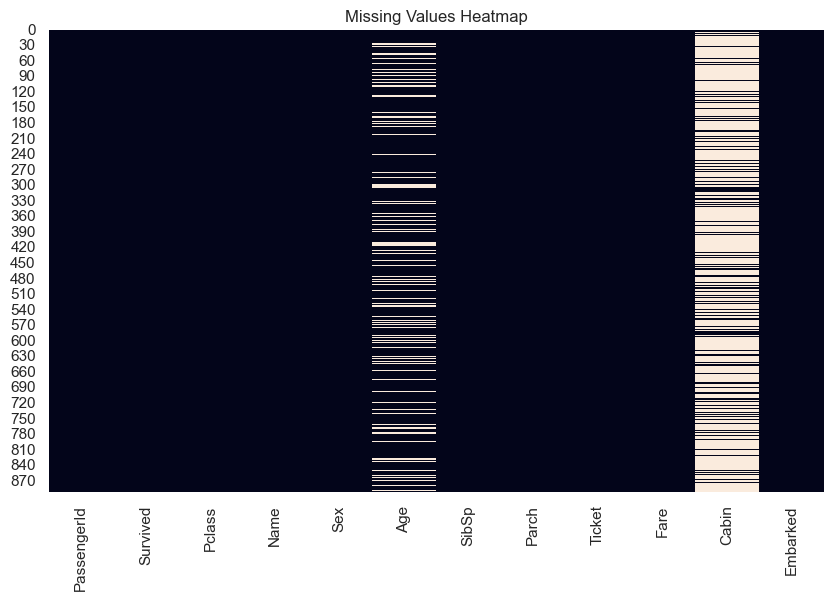

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

Missing values are concentrated in the Age, Cabin, and Embarked features and must be addressed during data cleaning.

## 4. Data Cleaning <a id="data-cleaning"></a>

This section handles missing values and removes non-informative features.

### 4.1 Drop Non-Predictive Identifier Columns

In [11]:
df = df.drop(columns=["PassengerId", "Ticket"])

PassengerId and Ticket were removed as they are identifiers and do not carry predictive information for survival.

### 4.2 Handle Cabin Feature

In [12]:
df["HasCabin"] = df["Cabin"].notna().astype(int)
df = df.drop(columns=["Cabin"])

Cabin was converted into a binary feature indicating whether a cabin was assigned, capturing useful signal while avoiding excessive missingness.

### 4.3 Handle Embarked

In [13]:
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

Missing values in Embarked were filled using the most frequent category, as the number of missing entries was minimal.

### 4.4 Handle Age

In [14]:
df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].transform(
    lambda x: x.fillna(x.median())
)

Age was imputed using the median value grouped by Sex and Passenger Class, preserving demographic patterns while avoiding data leakage.

### 4.5 Sanity Check

In [15]:
df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
HasCabin    0
dtype: int64

After cleaning, the dataset contains no missing values in the features used for modeling.

## 5. Feature Engineering <a id="feature-engineering"></a>

This section creates additional features that capture social and demographic patterns relevant to survival.

### 5.1 Family-Based Features

In [16]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

* **FamilySize** represents the total number of family members aboard the ship.
* **IsAlone** captures whether a passenger was traveling without family, which can influence survival likelihood.

### 5.2 Title Feature

In [17]:
# Extract title from name
df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

In [18]:
df["Title"].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

Most titles appear very infrequently and would result in sparse categories. To reduce dimensionality and improve generalization, rare titles are grouped into a single 'Rare' category.

In [19]:
df["Title"] = df["Title"].replace(
    ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"],
    "Rare"
)

df["Title"] = df["Title"].replace(
    ["Mlle", "Ms"],
    "Miss"
)

df["Title"] = df["Title"].replace(
    "Mme",
    "Mrs"
)

In [20]:
df["Title"].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

In [21]:
df.groupby("Title")["Survived"].mean()

Title
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.793651
Rare      0.347826
Name: Survived, dtype: float64

### 5.3 Drop Name Column

In [22]:
df = df.drop(columns=["Name"])

The Name feature was removed after extracting the Title, as the raw name does not generalize to unseen passengers.

In [23]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
HasCabin      0
FamilySize    0
IsAlone       0
Title         0
dtype: int64

## 6. Modeling Approach <a id="modeling-approach"></a>
This section outlines the modeling strategy, including preprocessing design, model choices, and evaluation methodology.

### 6.1 Problem Framing
This is a supervised binary classification problem where the goal is to predict passenger survival based on demographic and travel-related features.

### 6.2 Use Pipelines
A pipeline-based approach is used to ensure that all preprocessing steps (imputation, encoding, scaling) are applied consistently during training and
inference.

### 6.3 Feature Handling Strategy
* Numerical features will be imputed using median values and scaled.
* Categorical features will be imputed using the most frequent category and encoded using one-hot encoding. 
* Rare categories are handled during feature engineering to reduce sparsity.

### 6.4 Candidate Model
The following model will be evaluated:

- Logistic Regression (baseline, interpretable)

### 6.5 Evaluation Strategy
- Model performance will be evaluated using a stratified train-test split.
- Accuracy, precision, recall, and F1-score will be used to assess classification performance, with particular attention to recall for the survival class.


## 7. Model Training <a id="model-training"></a>

This section implements the modeling approach by training machine learning models using scikit-learn pipelines.

### 7.1 Train / Test Split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

The dataset is split into training and test sets using stratified sampling to preserve class distribution.

### 7.2 Define Feature Groups

In [26]:
numeric_features = ["Age", "Fare", "FamilySize"]

categorical_features = [
    "Sex",
    "Embarked",
    "Pclass",
    "Title",
    "IsAlone",
    "HasCabin"
]

### 7.3 Build Preprocessing Pipelines

#### Numeric Pipeline

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [28]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

#### Categorical Pipeline

In [29]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

### 7.4 Combine Using ColumnTransformer

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

### 7.5 Train Baseline Model — Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
log_reg = LogisticRegression(max_iter=1000)

### 7.6 Create Full Pipeline

In [33]:
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", log_reg)
])

### 7.7 Train the Model

In [34]:
log_reg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

## 8. Model Evaluation <a id="model-evaluation"></a>
This section evaluates the trained model using standard classification metrics to assess its predictive performance.

### 8.1 Generate Predictions

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [36]:
y_pred = log_reg_pipeline.predict(X_test)

### 8.2 Accuracy Score

In [37]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8379888268156425

Accuracy provides an overall measure of how often the model correctly predicts survival outcomes.

### 8.3 Classification Report

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       110
           1       0.80      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



### 8.4 Confusion Matrix

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[97, 13],
       [16, 53]])

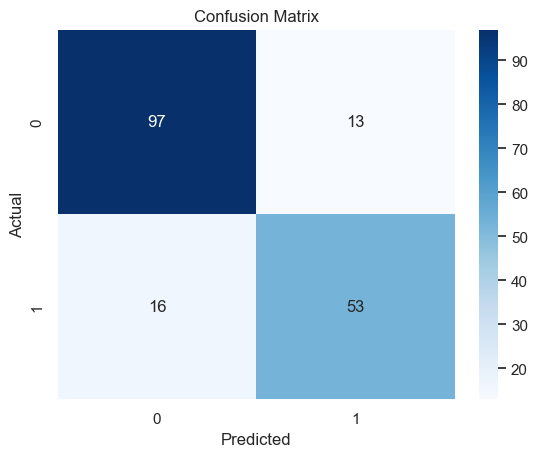

In [42]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 9. Export Model Artifacts <a id="export-model"></a>

This section serializes the trained model pipeline so it can be reused for inference in a API without retraining.

### 9.1 Export the Model

In [44]:
import os
import joblib

In [47]:
MODEL_PATH = "../artifacts/titanic_survival_model.joblib"
os.makedirs("../artifacts", exist_ok=True)

In [48]:
joblib.dump(log_reg_pipeline, MODEL_PATH)

['../artifacts/titanic_survival_model.joblib']

### 9.2 Verify Exported Model

In [49]:
loaded_model = joblib.load(MODEL_PATH)

In [50]:
loaded_model.predict(X_test.iloc[:5])

array([0, 0, 0, 0, 1])

The exported artifact contains:
- Feature preprocessing logic (imputation, scaling, encoding)
- Feature ordering and transformations
- Trained Logistic Regression model

## 10. Conclusion & Future Improvements <a id="conclusion"></a>

### 10.1 Conclusion

This project implemented an end-to-end machine learning workflow to predict passenger survival on the Titanic dataset. The process included exploratory data analysis, data cleaning, feature engineering, model training, evaluation, and deployment-ready model export.

A pipeline-based Logistic Regression model was selected to ensure consistency between training and inference, making the solution suitable for integration into an API-driven application.

### 10.2 Future Improvements

Potential improvements for future iterations include:

- Evaluating additional models such as Gradient Boosting to compare performance
- Hyperparameter tuning using cross-validation
- Incorporating feature importance analysis
- Adding model monitoring and drift detection
